In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,root_mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
df=pd.read_csv('D:\\INSEA\\Stage PFA\\Stage Ministère de finance\\data\\tourism\\TES_with_feuters.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.asfreq('MS')  # MS = Month Start
df = df.sort_index()
df['TES']=df['TES'].replace(0,1)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183 entries, 2010-02-01 to 2025-04-01
Freq: MS
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TES              183 non-null    float64
 1   marrakech_lag_1  183 non-null    float64
 2   review_count     183 non-null    float64
 3   NSI              183 non-null    float64
 4   is_pandemic      183 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 8.6 KB


In [4]:
for i in range(6):
    df[f"TES_lag_{i+1}"]=df['TES'].shift(i+1)

df.dropna(inplace=True)

In [5]:
matrice=df.corr()
matrice

,TES,marrakech_lag_1,review_count,NSI,is_pandemic,TES_lag_1,TES_lag_2,TES_lag_3,TES_lag_4,TES_lag_5,TES_lag_6
TES,1.000000,0.828266,0.139287,-0.049181,-0.661044,0.869928,0.816987,0.771046,0.726138,0.649563,0.593212
marrakech_lag_1,0.828266,1.000000,0.141658,-0.060218,-0.476172,0.871382,0.816390,0.743197,0.699869,0.664315,0.613762
review_count,0.139287,0.141658,1.000000,-0.441074,0.063854,0.019767,0.113466,0.195610,0.088244,0.113872,0.168139
NSI,-0.049181,-0.060218,-0.441074,1.000000,-0.015603,0.003146,-0.045878,-0.106656,-0.035614,-0.059028,-0.168866
is_pandemic,-0.661044,-0.476172,0.063854,-0.015603,1.000000,-0.660617,-0.660671,-0.663792,-0.661580,-0.645091,-0.611834
TES_lag_1,0.869928,0.871382,0.019767,0.003146,-0.660617,1.000000,0.868520,0.814152,0.773837,0.719425,0.641696
TES_lag_2,0.816987,0.816390,0.113466,-0.045878,-0.660671,0.868520,1.000000,0.866322,0.813606,0.769731,0.714731
TES_lag_3,0.771046,0.743197,0.195610,-0.106656,-0.663792,0.814152,0.866322,1.000000,0.866317,0.810274,0.765743
TES_lag_4,0.726138,0.699869,0.088244,-0.035614,-0.661580,0.773837,0.813606,0.866317,1.000000,0.866820,0.808665
TES_lag_5,0.649563,0.664315,0.113872,-0.059028,-0.645091,0.719425,0.769731,0.810274,0.866820,1.000000,0.864031


In [6]:
# df['TES_lag_1']=df['TES'].shift(1)
# df.dropna(inplace=True)

In [7]:
split=22
df_ts=df['TES']
train_ts = df_ts[:len(df_ts) - split]
hw_model = ExponentialSmoothing(train_ts, trend='add', seasonal='add', seasonal_periods=12).fit()
hw_features = pd.DataFrame({'HW_Level': hw_model.level, 'HW_Trend': hw_model.trend, 'HW_Season': hw_model.season})
residuals = hw_model.fittedvalues - train_ts
n_forecast = split

# Get the last components from training
last_level = hw_model.level[-1]
last_trend = hw_model.trend[-1]
seasonality = hw_model.season[-12:]  # seasonal_periods = 12
forecast_index = pd.date_range(train_ts.index[-1] + pd.DateOffset(months=1), periods=n_forecast, freq='MS')
# Build forecasted components manually
future_levels = [last_level + (i + 1) * last_trend for i in range(n_forecast)]
future_trends = [last_trend] * n_forecast
future_seasonality = [seasonality[i % 12] for i in range(n_forecast)]
#future_residuals = [0] * n_forecast  # Assuming unknown error = 0

hw_features_test = pd.DataFrame({
    'HW_Level': future_levels,
    'HW_Trend': future_trends,
    'HW_Season': future_seasonality,
    # 'HW_Residual': future_residuals
}, index=forecast_index)

hw_features = pd.concat([hw_features, hw_features_test])
hw_features.index = hw_features.index.tz_localize(None)
# Ensure both DataFrames have timezone-naive indexes before joining
df.index = df.index.tz_localize(None)
hw_features.index = hw_features.index.tz_localize(None)
# Join these new features with our main feature set
df = df.join(hw_features, how='left')
print("Holt-Winters components added as features.")


Holt-Winters components added as features.


C:\Users\masta\AppData\Local\Temp\ipykernel_16916\195518023.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_level = hw_model.level[-1]
C:\Users\masta\AppData\Local\Temp\ipykernel_16916\195518023.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_trend = hw_model.trend[-1]
C:\Users\masta\AppData\Local\Temp\ipykernel_16916\195518023.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  future_seasonality = [seasonality

In [8]:
l=list(df.columns)
l.remove('TES')
exog_variables= l#['marrakech_lag_1', 'review_count', 'NSI','is_pandemic','HW_Level','HW_Trend','HW_Season','TES_lag_1']

In [9]:
train=df.loc[:'12-2023']
test=df.loc['01-2024':]

X_train = train[exog_variables]
X_test = test[exog_variables]
y_train = train['TES']
y_test = test['TES']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("taille du train:",len(train),"\ntaille du test :",len(test))

taille du train: 161 
taille du test : 16


### Modling

In [10]:
alphas = np.logspace(-3, 3, 50)

In [11]:
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)
print(f"\nMeilleur alpha trouvé: {ridge_cv.alpha_:.4f}")


Meilleur alpha trouvé: 0.1600


In [12]:
ridge = Ridge(alpha=ridge_cv.alpha_,random_state=42)
ridge.fit(X_train_scaled, y_train)

Ridge(alpha=np.float64(0.15998587196060574), random_state=42)

In [13]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


--- Random Forest Model Evaluation 1 decomp---
RMSE: 105,137.91
MAPE: 12.00%
MAE: 93,249.14
R²: 0.05
AdjustedR²: -6.14


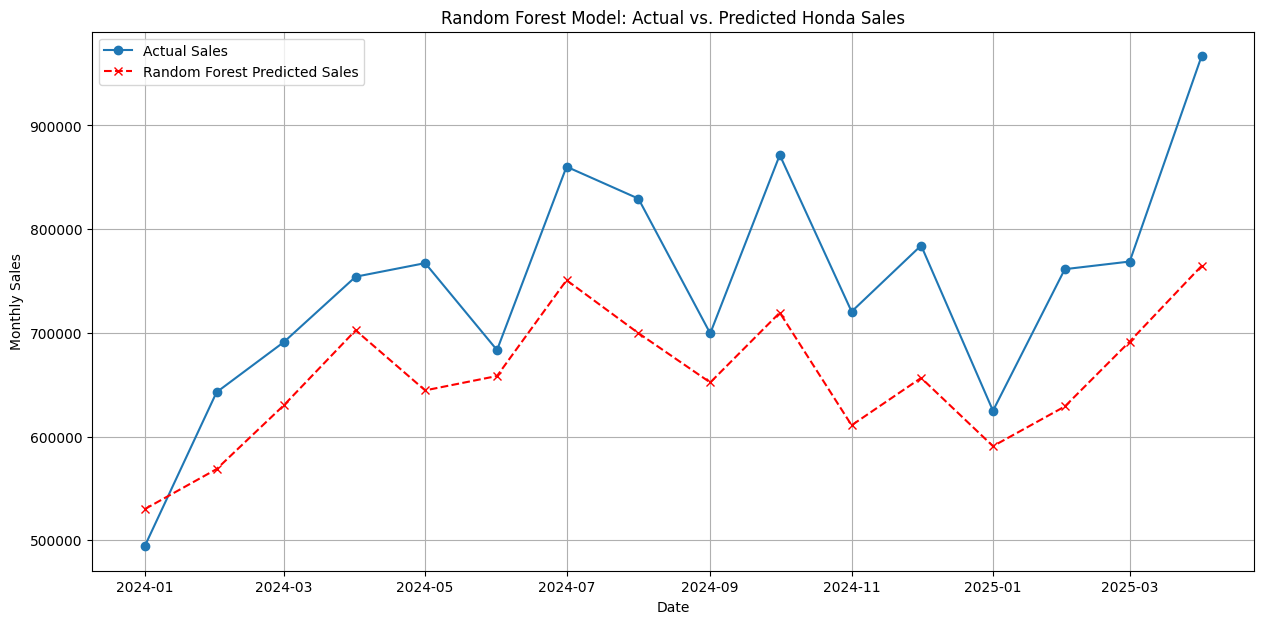

In [14]:
y_pred = ridge.predict(X_test_scaled)


rmse = root_mean_squared_error(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
n = X_test.shape[0]  # Number of observations
p = X_test.shape[1]  # Number of features
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print("\n--- Random Forest Model Evaluation 1 decomp---")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:,.2f}%")
print(f"MAE: {mae:,.2f}")
print(f"R²: {r2:,.2f}")
print(f"AdjustedR²: {adjusted_r2:,.2f}")

# Plot predictions vs. actuals
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test.values, label='Actual Sales', marker='o', linestyle='-')
plt.plot(y_test.index, y_pred, label='Random Forest Predicted Sales', marker='x', linestyle='--', color='red')
plt.title('Random Forest Model: Actual vs. Predicted Honda Sales')
plt.xlabel('Date')
plt.ylabel('Monthly Sales')
plt.legend()
plt.grid(True)
plt.show()

### Expanding window

In [15]:
# Préparer données
#alphas = np.logspace(-3, 3, 50)
# Expanding window avec contraintes réelles
def forecast(df, target='TES', test=18):
    l=list(df.columns)
    l.remove('TES')
    feats = l
    train_end = len(df) - test
    preds, acts , dates = [],[], []
    
    for i in range(test):
        # Train
        print('='*40,"le test némero ",i+1,'='*40)
        train = df.iloc[:train_end + i]
        X_train, y_train = train[feats], train[target]
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        
        #meilleur=optimize_hyperparameters(X_train, y_train)
        # ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
        # ridge_cv.fit(X_train_scaled, y_train)
        # print(f"\nMeilleur alpha trouvé: {ridge_cv.alpha_:.4f}")
        ridge = Ridge(alpha=0.4618,random_state=42)
        ridge.fit(X_train_scaled, y_train)
        
        # Test avec contrainte réelle
        test_row = df.iloc[[train_end + i]][feats].copy()
        
        test_row_scaled = scaler.transform(test_row)
        pred = ridge.predict(test_row_scaled)[0]
        preds.append(pred)
        acts.append(df.iloc[train_end + i][target])
        dates.append(df.index[train_end + i])
    
    # Métriques
    mae = mean_absolute_error(acts, preds)
    rmse = np.sqrt(mean_squared_error(acts, preds))
    r2 = r2_score(acts, preds)
    mape = 100 * np.mean(np.abs((np.array(acts) - np.array(preds)) / np.array(acts)))
    
    print("="*40,"Mrtric","="*40)
    print(f"MAE: {mae:,.1f} \nRMSE: {rmse:,.1f} \nMAPE: {mape:,.1f}%")
    print(f"R²: {r2:,.2f}")
    return pd.DataFrame({'actual': acts, 'predicted': preds} , index=dates)

# UTILISATION
# df = pd.read_csv('ventes.csv')  # Vos données
# df = prep(df, date='date', target='ventes')
# results = forecast(df, test=18)

In [16]:
results = forecast(df, test=18)

======================================== le test némero  1 ========================================
======================================== le test némero  2 ========================================
======================================== le test némero  3 ========================================
======================================== le test némero  4 ========================================
======================================== le test némero  5 ========================================
======================================== le test némero  6 ========================================
======================================== le test némero  7 ========================================
======================================== le test némero  8 ========================================
======================================== le test némero  9 ========================================
======================================== le test némero  10 ========================================

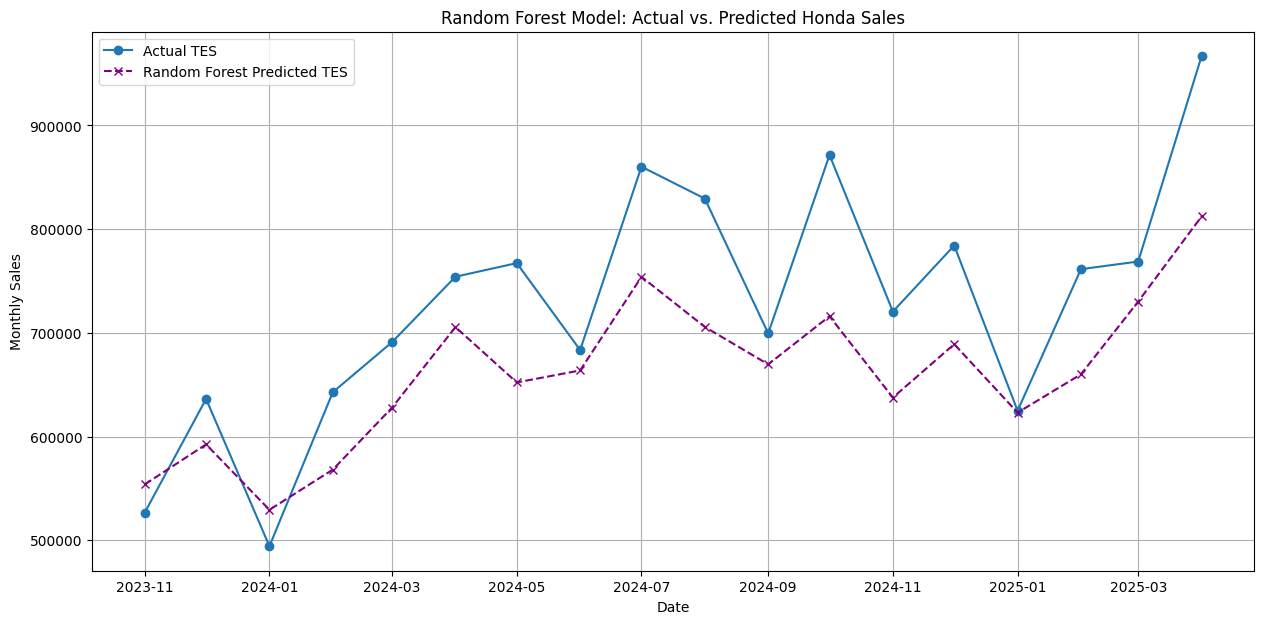

In [17]:
# Plot predictions vs. actuals
plt.figure(figsize=(15, 7))
plt.plot(results.index, results['actual'].values, label='Actual TES', marker='o', linestyle='-')
plt.plot(results.index, results['predicted'].values, label='Random Forest Predicted TES', marker='x', linestyle='--', color='purple')
plt.title('Random Forest Model: Actual vs. Predicted Honda Sales')
plt.xlabel('Date')
plt.ylabel('Monthly Sales')
plt.legend()
plt.grid(True)
plt.show()